# Build likelihood tables simulated protons and muons

In [1]:
%load_ext autoreload
%autoreload 2

import math
from itertools import product
import uproot
import awkward
import numpy as np
from scipy.stats import binned_statistic_2d
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import matplotlib
matplotlib.rcParams.update({'font.size': 12})

from calo_likelihood import caloLikelihood
from general_functions import *
from loaders import *
from initializers import *

In [2]:
today = 'calorimetry/reinteracting_protons/'

In [3]:
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/proton_muon_likelihoods/pdfs/plane0
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/proton_muon_likelihoods/pdfs/plane1
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/proton_muon_likelihoods/pdfs/plane2

In [4]:
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/proton_muon_likelihoods/performance_plots/

In [5]:
save_folder = '/home/nic/Dropbox/MicroBooNE/_fig/' + today + '/proton_muon_likelihoods/'
save_folder_pdfs = save_folder + 'pdfs/'
save_folder_performance = save_folder + 'performance_plots/'

In [6]:
branches = [
    'run',
    'sub',
    'evt',
    
    'backtracked_pdg',
    'backtracked_e',
    'backtracked_purity',
    'backtracked_completeness',
    'backtracked_overlay_purity',
    'backtracked_end_process',
    
    'backtracked_start_x',
    'backtracked_start_y',
    'backtracked_start_z',
    
    'backtracked_sce_start_x',
    'backtracked_sce_start_y',
    'backtracked_sce_start_z',
    
    'nplanehits_U',
    'nplanehits_V',
    'nplanehits_Y',
    'trk_score',

    'generation',
    'trk_daughters',
    'shr_daughters',

    'trk_sce_start_x',
    'trk_sce_start_y',
    'trk_sce_start_z',

    'trk_sce_end_x',
    'trk_sce_end_y',
    'trk_sce_end_z',
    
    'trk_theta',
    'trk_phi',

    'trk_dir_x',
    'trk_dir_y',
    'trk_dir_z',
    
    'trk_pid_chipr_u',
    'trk_pid_chipr_v',
    'trk_pid_chipr_y',
    'trk_pid_chimu_y',
    'trk_bragg_p_y',
    'trk_bragg_mu_y',
    'trk_bragg_p_three_planes',

    'trk_len',
    'trk_energy_proton',
    'longest',
    
    'is_hit_montecarlo_u',
    'is_hit_montecarlo_v',
    'is_hit_montecarlo_y',
    
    'dedx_u',
    'dedx_v',
    'dedx_y',
    
    'dqdx_u',
    'dqdx_v',
    'dqdx_y',
    
    'rr_u',
    'rr_v',
    'rr_y',

    'pitch_u',
    'pitch_v',
    'pitch_y',
    
    'dir_x_u',
    'dir_x_v',
    'dir_x_y',
    
    'dir_y_u',
    'dir_y_v',
    'dir_y_y',
    
    'dir_z_u',
    'dir_z_v',
    'dir_z_y',
]

In [7]:
# branches = [
#     'backtracked_pdg',
#     'backtracked_e',
#     'backtracked_purity',
#     'backtracked_completeness',
#     'backtracked_overlay_purity',
#     'backtracked_end_process',
# ]

# file_bnb = '~/Desktop/MicroBooNE/calorimetry_likelihood/v07/bnb_nu/out_mc_skimmed.root'

# folder = "nuselection"
# tree = "CalorimetryAnalyzer"
# root_file = uproot.open(file_bnb)[folder][tree]
# array_test = root_file.arrays(branches, namedecode="utf-8")

# total_tracks = len(array_test['backtracked_end_process'])
# for lab in np.unique(array_test['backtracked_end_process'].regular()):
#     print(f"{lab} {(array_test['backtracked_end_process'].regular() == lab).sum()/total_tracks:.2g}")

In [8]:
file_bnb = '~/Desktop/MicroBooNE/calorimetry_likelihood/v08/bnb_nu/out_mc_skimmed.root'

folder = "nuselection"
tree = "CalorimetryAnalyzer"

split_factor = 0.8
split_factor2 = 1.
root_file = uproot.open(file_bnb)[folder][tree]
entry_split = int(len(root_file) * split_factor)
entry_split2 = int(len(root_file) * split_factor2)
array_train = root_file.arrays(branches, namedecode="utf-8", entrystop=0)
array_test = root_file.arrays(branches, namedecode="utf-8", entrystart=entry_split, entrystop=entry_split2)

In [9]:
for array in [array_train, array_test]:
    initialisation_for_caloriemtry_data_mc(array)

/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/lib/general_functions.py:39: RuntimeWarning: divide by zero encountered in true_divide
  return 0.3 / cos


In [10]:
def selection_for_train(array):
    return (array['backtracked_completeness'] > 0.9) &\
           (array['backtracked_purity'] > 0.9) &\
           (array['start_is_fiducial']) &\
           (array['end_is_fiducial']) &\
           (array['non_inelastic']) &\
           (array['trk_daughters']==0) &\
           (array['shr_daughters']==0)

def selection_for_test(array):
    return (array['start_is_fiducial']) &\
           (array['end_is_fiducial']) &\
           (array['trk_daughters']==0) &\
           (array['shr_daughters']==0)

def muon_for_test(array):
    return selection_for_test(array) & (np.abs(array['backtracked_pdg'])==13)

def proton_for_test(array):
    return selection_for_test(array) & (np.abs(array['backtracked_pdg'])==2212)

def cosmic_for_test(array):
    return selection_for_test(array) & (np.abs(array['backtracked_pdg'])==0)

def selection_planes(array):
    aux = []
    for plane in ['_u', '_v', '_y']:
        aux.append(array['first_last_hit_mask'+plane])
    return aux

In [11]:
proton_for_test(array_test).sum()

30641

In [12]:
selection_train = selection_for_train(array_train)
selection_train_planes = selection_planes(array_train)
selection_test = selection_for_test(array_test)
selection_test_planes = selection_planes(array_test)

In [13]:
# for array in [array_train, array_test]:
#     array['residual range'] = array['rr_y']
#     array['pitch'] = array['pitch_y']
    
# parameters_names = ['rr', 'pitch']
# parameters_bin_edges = [[0., 2, 4, 7, 10, 15, 20, 30, 50, 100, 300, 2000],
#                   [.0, 0.6, 1, 1.5, 3, 30]]

# dedx_var = 'dedx'
# dedx_var_end = '_cali'
# dedx_bins = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 9, 10, 12, 15, 20, 25, 30, 35, 40, 45, 50]

# parameters = []
# dedx_vars = []
# for plane in ['u', 'v', 'y']:
#     if plane == 'y':
#         parameters.append(['residual range', 'pitch'])
#         dedx_vars.append(dedx_var+'_'+plane+dedx_var_end)
#     else:
#         parameters.append([parameter_name+'_'+plane for parameter_name in parameters_names])
#         dedx_vars.append(dedx_var+'_'+plane+dedx_var_end)

# pdgcode_var = 'backtracked_pdg'

In [14]:
parameters_names = ['rr', 'pitch']
parameters_bin_edges = [[0., 2, 4, 7, 10, 15, 20, 30, 50, 100, 300, 2000],
                  [0.3, 0.6, 1, 1.5, 3, 30]]

dedx_var = 'dedx'
dedx_var_end = '_cali'
dedx_bins = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 9, 10, 12, 15, 20, 25, 30, 35, 40, 45, 50]

parameters = []
dedx_vars = []
for plane in ['u', 'v', 'y']:
    parameters.append([parameter_name+'_'+plane for parameter_name in parameters_names])
    dedx_vars.append(dedx_var+'_'+plane+dedx_var_end)

pdgcode_var = 'backtracked_pdg'

In [15]:
caloLike_train = caloLikelihood(array_train, quality_mask=selection_train, quality_masks_planes=selection_train_planes)
caloLike_test = caloLikelihood(array_test, quality_mask=selection_test, quality_masks_planes=selection_test_planes)

caloLike_train.setPdgCodeVar(pdgcode_var)
caloLike_test.setPdgCodeVar(pdgcode_var)

In [16]:
for i in [0, 1, 2]:
    caloLike_train.setVariablesBinning(i, parameters[i], parameters_bin_edges, dedx_vars[i], dedx_bins)
    caloLike_train.buildLookUpTableMC(i, 13)    
    caloLike_train.buildLookUpTableMC(i, 2212)    
    caloLike_train.buildLookUpLogLikelihoodRatio(i, [13, 2212])
    caloLike_test.setVariablesBinning(i, parameters[i], parameters_bin_edges, dedx_vars[i], dedx_bins)

/home/nic/.local/lib/python3.7/site-packages/numpy/lib/histograms.py:1118: RuntimeWarning: invalid value encountered in true_divide
  hist /= s


In [17]:
caloLike_train.addCalorimetryVariables(caloLike_test.array, pdg_codes=[13, 2212])
caloLike_train.addCalorimetryVariablesFromLLRTable(caloLike_test.array, selection_test_planes)

In [18]:
# caloLike_train.printCplusplusLookUp(filename='/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/calorimetry_likelihood/larsoft_dev/LLRPID_proton_muon_lookup_recali.h', planes=[0, 1, 2])

In [19]:
# caloLike_train.save(filename='/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/calorimetry_likelihood/dumped_objects/proton_muon_lookup.dat')

In [20]:
caloLike_train.logLikelihoodRatioOneHit(2, 2.5, [27, 4])

nan

# Load the proton muon lookup tables

In [21]:
load_lookup = True

# Plot of the pdfs/likelihoods in bins of residual range and pitch

### Plot PDFs from lookup tables

In [22]:
if load_lookup:
    load_lookup_table(caloLike_train)

NameError: name 'save_folder_pdfs' is not defined

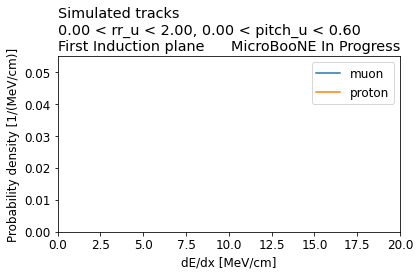

In [61]:
for plane_num in [0, 1, 2]:
    bin_centers = product(*caloLike_train.parameters_bin_centers[plane_num])
    for bin_center in bin_centers:
        caloLike_train.plotLookUpDedxMC(plane_num=plane_num, 
                                  pdg_code=13, 
                                  parameters_value=bin_center, 
                                  label='muon')
        caloLike_train.plotLookUpDedxMCfancy(plane_num=plane_num, 
                                  pdg_code=2212, 
                                  parameters_value=bin_center, 
                                  label='proton')
        plt.xlim(0, 20)
        plt.ylim(bottom=0)
        plt.tight_layout()
        save_label = 'plane{}/rr_{:05.0f}_pitch_{:04.1f}'.format(plane_num,bin_center[0], bin_center[1]).replace('.', '')
        plt.savefig(save_folder_pdfs + save_label+ '.png', dpi=250)
        plt.savefig(save_folder_pdfs + save_label+ '.pdf')
        plt.close()

In [24]:
today

'calorimetry/reinteracting_protons/'

In [23]:
# for paper
import matplotlib
matplotlib.rcParams.update({'font.size': 13})
save_folder_paper = '/home/nic/Dropbox/MicroBooNE/_fig/' + today + 'lookup_table/'
!mkdir -p /home/nic/Dropbox/MicroBooNE/_fig/$today/lookup_table/

for plane_num in [0, 1, 2]:
    bin_centers = product(*caloLike_train.parameters_bin_centers[plane_num])
    for bin_center in bin_centers:
        if ((plane_num == 2) and (bin_center[0] == 5.5) and (bin_center[1] in [0.44999999999999996, 0.8, 1.25])) or\
           ((plane_num == 2) and (bin_center[1] == 0.44999999999999996) and (bin_center[0] in [3, 12.5, 25])) or\
           ((bin_center[0] == 8.5) and (bin_center[1] == 0.8)):
            caloLike_train.plotLookUpDedxMC(plane_num=plane_num, 
                                      pdg_code=13, 
                                      parameters_value=bin_center, 
                                      label='muon')
            caloLike_train.plotLookUpDedxMCfancy(plane_num=plane_num, 
                                      pdg_code=2212, 
                                      parameters_value=bin_center, 
                                      label='proton')
            l = plt.legend(frameon=False, title=caloLike_train.produceLabelParameters(plane_num, bin_center, fancy=True))
            plt.setp(l.get_title(), multialignment='center')
            plt.xlim(0, 20)
            plt.ylim(bottom=0)
            plt.title('MicroBooNE Simulation', loc='left')
            plt.title('', loc='right')
            save_label = 'plane_{}_rr_{:05.0f}_pitch_{:04.1f}'.format(plane_num, bin_center[0], bin_center[1]).replace('.', '')
            plt.savefig(save_folder_paper + save_label+ '.png', dpi=250)
            plt.savefig(save_folder_paper + save_label+ '.pdf')
            plt.close()

# Plots of the PID variables

In [21]:
if load_lookup:
    compute_pid(caloLike_test.array)

In [22]:
interesting_variables = [
                         'trk_pid_chipr_y',
#                          'trk_pid_chimu_y',
#                          'trk_bragg_p_y',
#                          'trk_bragg_mu_y',
#                          'trk_bragg_p_three_planes',
#                          'llr_sum_0',
#                          'llr_sum_1',
                         'llr_sum_2',
#                          'llr_01',
                         'llr_012',
                        ]

interesting_variables = [
    'llr_012',
    'llr_sum_2',
    'trk_pid_chipr_y',
                        ]

variable_labels = {
    'trk_pid_chipr_y': '$\chi^2_{proton}$ Y',
    'trk_pid_chimu_y': '$\chi^2_{\mu}$ Y',
    'trk_bragg_p_y': 'Bragg likelihood Y',
    'trk_bragg_mu_y': 'Bragg likelihood muon Y',
    'trk_bragg_p_three_planes': 'Bragg likelihood UVY',
    'llr_sum_0': 'LLR U',
    'llr_sum_1': 'LLR V',
    'llr_sum_2': 'LLR Y',
    'llr_01': 'LLR UV',   
    'llr_012': 'LLR UVY',   
}

variable_labels_fancy = {
    'trk_pid_chipr_y': '$\chi^2_{proton}$',
#     'trk_pid_chipr_y': 'Wihout considering the detector anisotropies',
#     'trk_pid_chimu_y': '$\chi^2_{\mu}$ collection plane',
#     'trk_bragg_p_y': 'Bragg likelihood collection plane',
#     'trk_bragg_mu_y': 'Bragg likelihood muon collection plane',
#     'trk_bragg_p_three_planes': 'Bragg likelihood all planes',
#     'llr_sum_0': 'LogLikelihoodRatio (this work) first induction plane',
#     'llr_sum_1': 'LogLikelihoodRatio (this work) second induction plane',
    'llr_sum_2': r'Collection plane $\mathcal{P}$',
#     'llr_01': 'LogLikelihoodRatio (this work) first and second induction plane',   
    'llr_012': r'Three-plane $\mathcal{P}$',   
}

for variable in interesting_variables:
    if 'llr' in variable:
        scale = 100
    elif 'bragg' in variable:
        scale = 1
    else:
        scale = 20
    add_norm_variable(caloLike_test.array, variable, scale)

In [ ]:
bins = 41
range = [-1, 1]
kwargs = {'histtype':'step'}
for var in interesting_variables:
    variable = var + '_n'
    caloLike_test.plotVariableMC(variable, bins, range, function_mask=proton_for_test, quality_mask=True, label='proton', **kwargs);
    caloLike_test.plotVariableMC(variable, bins, range, function_mask=muon_for_test, quality_mask=True, label='muon', **kwargs);
    caloLike_test.plotVariableMCFancy(variable, bins, range, function_mask=cosmic_for_test, quality_mask=True, label='cosmic', **kwargs);
    plt.legend(loc='upper left')
    plt.xlabel(variable_labels[var])
    plt.tight_layout()
#     plt.savefig(save_folder_performance + variable + '.png', dpi=250)
#     plt.savefig(save_folder_performance + variable + '.pdf')
    plt.close()

# ROC curves

NameError: name 'save_folder_paper' is not defined

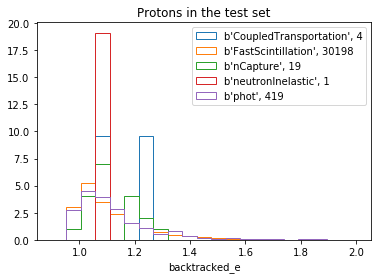

In [23]:
ar = caloLike_test.array
proton_mask = (ar['backtracked_pdg'] == 2212)
ranges ={
    'backtracked_e' : [0.9, 2],
    'proton_momentum' : [0, 2],
    'llr_012_n': [-1, 1]
}
for var in ['backtracked_e', 'llr_012_n']:
    for label in np.unique(ar['backtracked_end_process'][proton_mask].regular()):
        label_mask = (ar['backtracked_end_process'].regular() == label)
        selection_mask = selection_for_test(ar)
        total_mask = (proton_mask & label_mask & selection_mask)
        plt.hist(ar[var][total_mask], bins=21, range=ranges[var],
                 histtype='step', density=True, label=f"{label}, {(total_mask).sum()}")
    
    plt.legend()
    plt.xlabel(var)
    plt.title("Protons in the test set")
    plt.savefig(save_folder_paper + f"test_proton_{var}.png", dpi=250)
    plt.close()

NameError: name 'save_folder_paper' is not defined

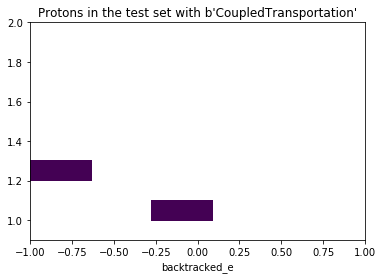

In [24]:
from matplotlib.colors import LogNorm

for label in np.unique(ar['backtracked_end_process'][proton_mask].regular()):
    label_mask = (ar['backtracked_end_process'].regular() == label)
    selection_mask = selection_for_test(ar)
    total_mask = (proton_mask & label_mask & selection_mask)
    plt.hist2d(ar['llr_012_n'][total_mask], ar['backtracked_e'][total_mask], bins=[11, 11], range=[ranges['llr_012_n'], ranges['backtracked_e']], norm=LogNorm())

    plt.xlabel('llr_012_n')
    plt.xlabel('backtracked_e')
    plt.title(f"Protons in the test set with {label}")
    plt.savefig(save_folder_paper + f"test_proton2d_{label}.png", dpi=250)
    plt.close()

In [24]:
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today
save_folder = f'/home/nic/Dropbox/MicroBooNE/_fig/{today}'

In [25]:
ar = caloLike_test.array
ranges ={
    'backtracked_e' : [0.9, 2],
    'proton_momentum' : [0, 2],
    'llr_012_n': [-1, 1]
}
ar['proton_momentum'] = np.sqrt(ar['backtracked_e']**2 - 0.938**2)
ar['proton_momentum_reco'] = np.sqrt((0.938+ar['trk_energy_proton'])**2 - 0.938**2)
ar['proton_momentum_relative_resolution'] = ar['proton_momentum_reco']/ar['proton_momentum'] - 1

proton_mask = (ar['backtracked_pdg'] == 2212)
selection_mask = selection_for_test(ar)
total_mask = (proton_mask & selection_mask)

/home/nic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in square
  import sys
/home/nic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


In [67]:
#compute the average dE/dx in the last 5 cm
end_length = 5
dedx_values = np.zeros(shape=len(ar['trk_len']), dtype=float)
nan_values = np.zeros(shape=len(ar['trk_len']))
for plane in ['u', 'v', 'y']:
    this_dedx_values = ar[f'dedx_{plane}'][(ar[f'rr_{plane}'] < end_length) & (ar[f'first_last_hit_mask_{plane}'])].mean()
    this_nan_values = np.isnan(this_dedx_values)
    this_dedx_values[this_nan_values] = 0.
    dedx_values += this_dedx_values
    nan_values += this_nan_values
ar[f'dedx_mean_{end_length}'] = dedx_values/(3-nan_values)

/home/nic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


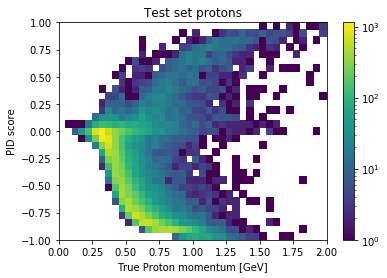

In [87]:
# label_mask = (ar['backtracked_end_process'].regular() == b'FastScintillation')
selection_mask = selection_for_test(ar)
total_mask = (proton_mask & selection_mask)
plt.hist2d(ar['proton_momentum'][total_mask], 
           ar['llr_012_n'][total_mask],
           bins=[40, 31], 
           range=[ranges['proton_momentum'], ranges['llr_012_n']],
           norm=LogNorm())

plt.xlabel('True Proton momentum [GeV]')
plt.ylabel('PID score')

plt.title(f"Test set protons")
plt.colorbar()
plt.savefig(save_folder + f"true_momentum_vs_pid.png", dpi=250)

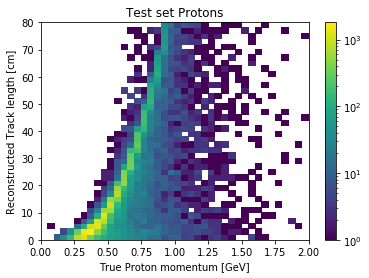

In [83]:
proton_mask = (ar['backtracked_pdg'] == 2212)
# label_mask = (ar['backtracked_end_process'].regular() == b'FastScintillation')
selection_mask = selection_for_test(ar)
total_mask = (proton_mask & selection_mask)
plt.hist2d(ar['proton_momentum'][total_mask], 
           ar['trk_len'][total_mask],
           bins=[40, 40], 
           range=[ranges['proton_momentum'], [0, 80]],
           norm=LogNorm())

plt.xlabel('True Proton momentum [GeV]')
plt.ylabel('Reconstructed Track length [cm]')

plt.title(f"Test set Protons")
plt.colorbar()
plt.savefig(save_folder + f"track_length_vs_true_momentum.png", dpi=250)

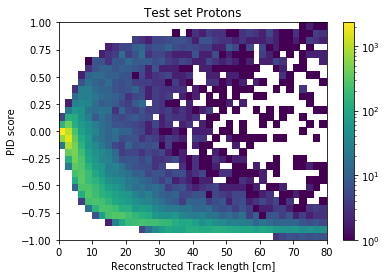

In [85]:
proton_mask = (ar['backtracked_pdg'] == 2212)
# label_mask = (ar['backtracked_end_process'].regular() == b'FastScintillation')
selection_mask = selection_for_test(ar)
total_mask = (proton_mask & selection_mask)
plt.hist2d(ar['trk_len'][total_mask], 
           ar['llr_012_n'][total_mask], 
           bins=[40, 31], 
           range=[[0, 80], ranges['llr_012_n']],
           norm=LogNorm())

plt.xlabel('Reconstructed Track length [cm]')
plt.ylabel('PID score')
plt.title(f"Test set Protons")
plt.colorbar()
plt.savefig(save_folder + f"pid_vs_track_length.png", dpi=250)

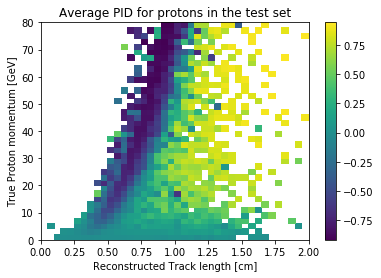

In [86]:
from scipy.stats import binned_statistic_2d

total_mask = (proton_mask & selection_mask)

statistic, x_edge, y_edge, binnumber = binned_statistic_2d(ar['proton_momentum'][total_mask], 
                    ar['trk_len'][total_mask],
                    ar['llr_012_n'][total_mask], 
                    statistic='mean', 
                    bins=[40, 40], 
                    range=[ranges['proton_momentum'], [0, 80]],)

plt.pcolormesh(x_edge, y_edge, statistic.T)
plt.xlabel('True Proton momentum [GeV]')
plt.ylabel('Reconstructed Track length [cm]')
plt.title(f"Average PID for protons in the test set")
plt.colorbar()
plt.savefig(save_folder + f"average_pid_inbinsof_true_momentum_vs_track_length.png", dpi=250)

In [70]:
def hist_2d_column_normalised(var1, var2, bins, range, norm='unity'):
    contents, x_edge, y_edge = np.histogram2d(var1, var2, bins=bins, range=range)
    maxs = np.max(contents, axis=1)
    if norm == 'unity':
        contents /= maxs[:, np.newaxis]
    plt.pcolormesh(x_edge, y_edge, contents.T)

/home/nic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


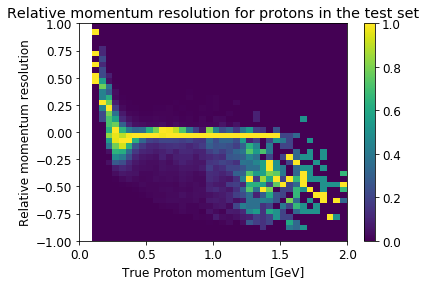

In [117]:
total_mask = (proton_mask & selection_mask)

hist_2d_column_normalised(ar['proton_momentum'][total_mask], 
                                 ar['proton_momentum_relative_resolution'][total_mask], 
                                 bins=[40, 40], 
                    range=[[0, 2], [-1, 1]],)

plt.xlabel('True Proton momentum [GeV]')
plt.ylabel('Relative momentum resolution')
plt.title(f"Relative momentum resolution for protons in the test set")
plt.colorbar()

plt.savefig(save_folder + f"relative_resolution_vs_true_proton_momentum.png", bbox_inches='tight', dpi=250)

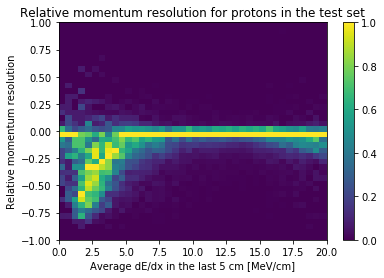

In [95]:
total_mask = (proton_mask & selection_mask)

hist_2d_column_normalised(ar['dedx_mean_5'][total_mask], 
                                 ar['proton_momentum_relative_resolution'][total_mask], 
                                 bins=[40, 40], 
                    range=[[0, 20], [-1, 1]],)

plt.xlabel('Average dE/dx in the last 5 cm [MeV/cm]')
plt.ylabel('Relative momentum resolution')
plt.title(f"Relative momentum resolution for protons in the test set")
plt.colorbar()

plt.savefig(save_folder + f"relative_resolution_vs_dedx_end_mean.png", bbox_inches='tight', dpi=250)

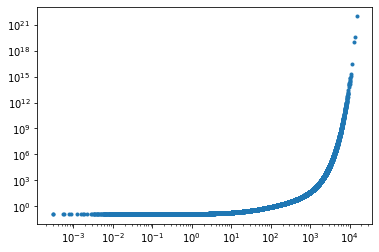

In [82]:
plt.plot(ar['dqdx_y'].flatten(), ar['dedx_y'].flatten(), '.')
plt.xscale('log')
plt.yscale('log')

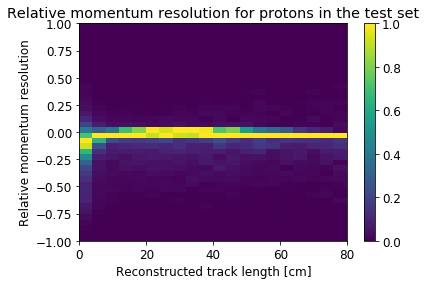

In [115]:
total_mask = (proton_mask & selection_mask)

hist_2d_column_normalised(ar['trk_len'][total_mask], 
                                 ar['proton_momentum_relative_resolution'][total_mask], 
                                 bins=[20, 40], 
                    range=[[0, 80], [-1, 1]],)

plt.xlabel('Reconstructed track length [cm]')
plt.ylabel('Relative momentum resolution')
plt.title(f"Relative momentum resolution for protons in the test set")
plt.colorbar()

plt.savefig(save_folder + f"relative_resolution_vs_reco_track_length.png", bbox_inches='tight', dpi=250)

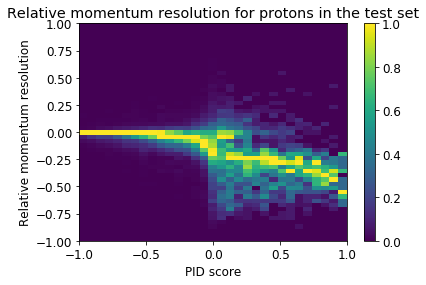

In [118]:
total_mask = (proton_mask & selection_mask)

hist_2d_column_normalised(ar['llr_012_n'][total_mask], 
                                 ar['proton_momentum_relative_resolution'][total_mask], 
                                 bins=[31, 51], 
                    range=[[-1, 1], [-1, 1]],)

plt.xlabel('PID score')
plt.ylabel('Relative momentum resolution')
plt.title(f"Relative momentum resolution for protons in the test set")
plt.colorbar()

plt.savefig(save_folder + f"relative_resolution_vs_pid_score.png", bbox_inches='tight', dpi=250)

/home/nic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


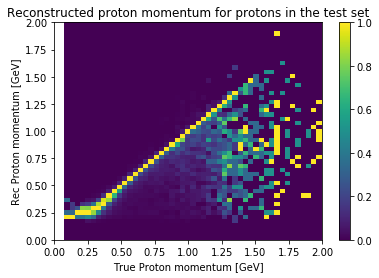

In [29]:
total_mask = (proton_mask & selection_mask)

hist_2d_column_normalised(ar['proton_momentum'][total_mask], 
                                 ar['proton_momentum_reco'][total_mask], 
                                 bins=[51, 51], 
                    range=[[0, 2], [0, 2]],)

plt.xlabel('True Proton momentum [GeV]')
plt.ylabel('Rec Proton momentum [GeV]')
plt.title(f"Reconstructed proton momentum for protons in the test set")
plt.colorbar()

plt.savefig(save_folder + f"reco_vs_true_proton_momentum.png", bbox_inches='tight', dpi=250)

/home/nic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


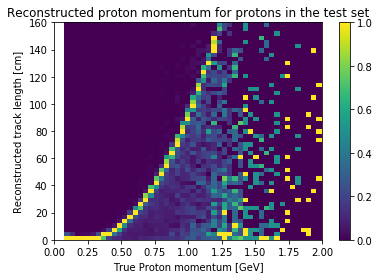

In [42]:
total_mask = (proton_mask & selection_mask)

hist_2d_column_normalised(ar['proton_momentum'][total_mask], 
                                 ar['trk_len'][total_mask], 
                                 bins=[51, 51], 
                    range=[[0, 2], [0, 160]],)

plt.xlabel('True Proton momentum [GeV]')
plt.ylabel('Reconstructed track length [cm]')
plt.title(f"Reconstructed proton momentum for protons in the test set")
plt.colorbar()

plt.savefig(save_folder + f"reco_track_length_vs_true_proton_momentum.png", bbox_inches='tight', dpi=250)

In [31]:
total_mask = (proton_mask & selection_mask)
cuts = [-1, -0.2, 0.2, 1]

for pid_min, pid_max in zip(cuts[:-1], cuts[1:]):
    pid_mask = (ar['llr_012_n'] > pid_min) & (ar['llr_012_n'] < pid_max)
    total_mask = (proton_mask & selection_mask & pid_mask)
    hist_2d_column_normalised(ar['trk_len'][total_mask], 
                                     ar['proton_momentum_relative_resolution'][total_mask], 
                                     bins=[20, 40], 
                        range=[[0, 80], [-1, 1]],)

    plt.xlabel('Reconstructed track length [cm]')
    plt.ylabel('Relative momentum resolution')
    plt.title(f"Relative momentum resolution for protons in the test set\n{pid_min} < PID < {pid_max}")
    plt.colorbar()

    plt.savefig(save_folder + f"relative_resolution_vs_reco_track_length_pid_{pid_min}_{pid_max}.png", bbox_inches='tight', dpi=250)
    plt.close()

/home/nic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [96]:
total_mask = (proton_mask & selection_mask)
cuts = [-1, -0.2, 0.2, 1]

for pid_min, pid_max in zip(cuts[:-1], cuts[1:]):
    pid_mask = (ar['llr_012_n'] > pid_min) & (ar['llr_012_n'] < pid_max)
    total_mask = (proton_mask & selection_mask & pid_mask)
    hist_2d_column_normalised(ar['dedx_mean_5'][total_mask], 
                                     ar['proton_momentum_relative_resolution'][total_mask], 
                                     bins=[20, 40], 
                        range=[[0, 20], [-1, 1]],)

    plt.xlabel('Average dE/dx in the last 5 cm [MeV/cm]')
    plt.ylabel('Relative momentum resolution')
    plt.title(f"Relative momentum resolution for protons in the test set\n{pid_min} < PID < {pid_max}")
    plt.colorbar()

    plt.savefig(save_folder + f"relative_resolution_vs_average_dedx_end_pid_{pid_min}_{pid_max}.png", bbox_inches='tight', dpi=250)
    plt.close()

In [34]:
total_mask = (proton_mask & selection_mask)
cuts = [0, 10, 20, 100]

for len_min, len_max in zip(cuts[:-1], cuts[1:]):
    len_mask = (ar['trk_len'] > len_min) & (ar['trk_len'] < len_max)
    total_mask = (proton_mask & selection_mask & len_mask)
    hist_2d_column_normalised(ar['llr_012_n'][total_mask], 
                                     ar['proton_momentum_relative_resolution'][total_mask], 
                                     bins=[20, 40], 
                        range=[[-1, 1], [-1, 1]],)

    plt.xlabel('Track PID')
    plt.ylabel('Relative momentum resolution')
    plt.title(f"Relative momentum resolution for protons in the test set\n{len_min} < track length < {len_max}")
    plt.colorbar()

    plt.savefig(save_folder + f"relative_resolution_vs_pid_reco_track_length_{len_min}_{len_max}.png", bbox_inches='tight', dpi=250)
    plt.close()

/home/nic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


/home/nic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


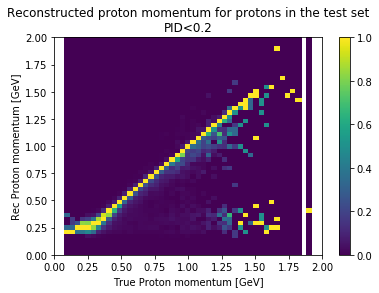

In [106]:
#selected protons: pid < 0.2
total_mask = (proton_mask & selection_mask & (ar['llr_012_n'] < 0.2))

hist_2d_column_normalised(ar['proton_momentum'][total_mask], 
                                 ar['proton_momentum_reco'][total_mask], 
                                 bins=[51, 51], 
                    range=[[0, 2], [0, 2]],)

plt.xlabel('True Proton momentum [GeV]')
plt.ylabel('Rec Proton momentum [GeV]')
plt.title(f"Reconstructed proton momentum for protons in the test set\nPID<0.2")
plt.colorbar()

# plt.savefig(save_folder + f"reco_vs_true_proton_momentum.png", bbox_inches='tight', dpi=250)

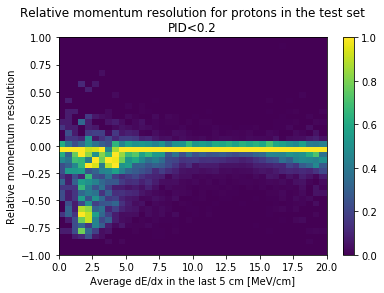

In [107]:
#selected protons: pid < 0.2
total_mask = (proton_mask & selection_mask & (ar['llr_012_n'] < 0.2))

hist_2d_column_normalised(ar['dedx_mean_5'][total_mask], 
                                 ar['proton_momentum_relative_resolution'][total_mask], 
                                 bins=[40, 40], 
                    range=[[0, 20], [-1, 1]],)

plt.xlabel('Average dE/dx in the last 5 cm [MeV/cm]')
plt.ylabel('Relative momentum resolution')
plt.title(f"Relative momentum resolution for protons in the test set\nPID<0.2")
plt.colorbar()

# plt.savefig(save_folder + f"relative_resolution_vs_dedx_end_mean.png", bbox_inches='tight', dpi=250)

/home/nic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  
/home/nic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


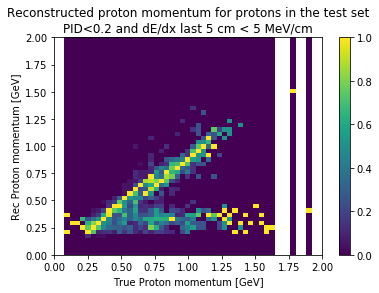

In [109]:
#selected protons: pid < 0.2
total_mask = (proton_mask & selection_mask & (ar['llr_012_n'] < 0.2) & (ar['dedx_mean_5']<5))

hist_2d_column_normalised(ar['proton_momentum'][total_mask], 
                                 ar['proton_momentum_reco'][total_mask], 
                                 bins=[51, 51], 
                    range=[[0, 2], [0, 2]],)

plt.xlabel('True Proton momentum [GeV]')
plt.ylabel('Rec Proton momentum [GeV]')
plt.title(f"Reconstructed proton momentum for protons in the test set\nPID<0.2 and dE/dx last 5 cm < 5 MeV/cm")
plt.colorbar()

# plt.savefig(save_folder + f"reco_vs_true_proton_momentum.png", bbox_inches='tight', dpi=250)

In [104]:
(proton_mask & selection_mask & (ar['llr_012_n'] < 0.2) & (ar['dedx_mean_5']>5)).sum()

/home/nic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


27245

In [110]:
(proton_mask & selection_mask & (ar['llr_012_n'] < 0.2)).sum()

29006

In [20]:
import matplotlib
matplotlib.rcParams.update({'font.size': 15})
save_folder_paper = '/home/nic/Dropbox/MicroBooNE/_fig/' + today

var = llr_012
var = llr_sum_2
var = trk_pid_chipr_y


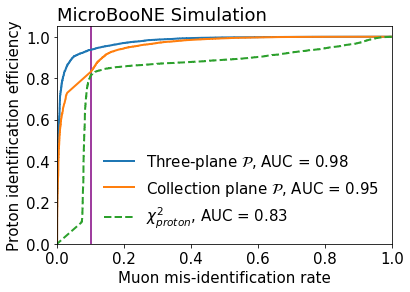

In [43]:
out = []
with_vertical_line = 0.1
# plt.figure(figsize=[6., 4.4])
for variable in interesting_variables:
    out.append(caloLike_test.rocCurve(variable=variable+'_n', 
         pdg_codes=[13, 2212], 
         plot=True,
         variable_label=variable_labels_fancy[variable]))
    print(f"var = {variable}")
#     for mis_id in [0.01, 0.05, 0.1, 0.15, 0.2]:
#         print(f"cut_value {np.interp(mis_id, out[i][1][::-1], out[i][3][::-1]):.3g}, mis-id {100*mis_id}%, eff {100*np.interp(mis_id, out[i][1][::-1], out[i][2][::-1]):.3g}%")

if with_vertical_line is not None:
    plt.vlines(with_vertical_line, 0., plt.gca().get_ylim()[1], 'purple')
plt.title('MicroBooNE Simulation', loc='left')
plt.title('', loc='right')
plt.xlabel('Muon mis-identification rate')
plt.ylabel('Proton identification efficiency')
# plt.tight_layout()
if with_vertical_line is not None:
    plt.savefig(save_folder_paper + 'roc_curves_with_vline.pdf', bbox_inches='tight')
    plt.savefig(save_folder_paper + 'roc_curves_with_vline.png', dpi=250)
else:
    plt.savefig(save_folder_paper + 'roc_curves.pdf', bbox_inches='tight')
    plt.savefig(save_folder_paper + 'roc_curves.png', dpi=250)

In [ ]:
# roc curves 1d
def selection_function(array, parameter, bin_range):
    return (array[parameter] >= bin_range[0]) &\
           (array[parameter] < bin_range[1])

pdg_codes = [13, 2212]
interesting_variables = [
                        'trk_pid_chipr_y',
                         'trk_bragg_p_three_planes',
                         'trk_bragg_p_y',
                         'llr_01',
                         'llr_sum_2',
                         'llr_012',
                        ]

parameter_names = ['trk_theta', 'trk_phi', 'trk_len'] #, 'backtracked_e']?
parameter_bin_edges = [np.linspace(0, np.pi, 20), np.linspace(-np.pi, np.pi, 20), np.linspace(0, 100, 20)]
paramter_labels = [r'Track $\theta$', r'Track $\phi$', 'Track length [cm]']

for name, bin_edges, label in zip(parameter_names, parameter_bin_edges, paramter_labels):
    for variable in interesting_variables:
        caloLike_test.auc1D(variable+'_n', 
                            pdg_codes, 
                            selection_function, 
                            name, 
                            bin_edges,
                            legend_label=variable_labels[variable])
    
    plt.xlabel(label)
    plt.legend()
    plt.title('Proton/muon separation\nSimulated tracks', loc='left')
    plt.tight_layout()
    plt.savefig(save_folder_performance+'auc1d_'+name+'.png', dpi=250)
    plt.savefig(save_folder_performance+'auc1d_'+name+'.pdf')
    plt.close()

In [44]:
# roc curves 1d, for paper
def selection_function(array, parameter, bin_range):
    return (array[parameter] >= bin_range[0]) &\
           (array[parameter] < bin_range[1])

pdg_codes = [13, 2212]
interesting_variables = [
                        'llr_012',
                        'llr_sum_2',
                        'trk_pid_chipr_y',
                        ]

parameter_names = ['trk_phi']
parameter_bin_edges = [np.linspace(-np.pi, np.pi, 20)]
paramter_labels = [r'Azimuthal angle $\phi$']

# plt.figure(figsize=[6., 4.5])
for name, bin_edges, label in zip(parameter_names, parameter_bin_edges, paramter_labels):
    for variable in interesting_variables:
        caloLike_test.auc1D(variable+'_n', 
                            pdg_codes, 
                            selection_function, 
                            name, 
                            bin_edges,
                            legend_label=variable_labels_fancy[variable])
    
    plt.xlabel(label)
    plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r'$-180\degree$', r'$-90\degree$', r'$0\degree$', r'$90\degree$', r'$180\degree$'])
    plt.ylim(0.47, 1.)
#     plt.yticks([0.5, 1.], ['random\nguess', 'always\ncorrect'])
    plt.ylabel('Area under the ROC curve')
    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles, labels, frameon=False)
    plt.title('MicroBooNE Simulation', loc='left')
    plt.title('', loc='right')
#     plt.tight_layout()
    plt.savefig(save_folder_paper+'auc_paper_'+name+'.png', dpi=250)
    plt.savefig(save_folder_paper+'auc_paper_'+name+'.pdf', bbox_inches='tight')
    plt.close()

In [19]:
# roc curves 1d, for plots for presentation at APS grad slam
def selection_function(array, parameter, bin_range):
    return (array[parameter] >= bin_range[0]) &\
           (array[parameter] < bin_range[1])

pdg_codes = [13, 2212]
interesting_variables = [
#                         'trk_bragg_p_y',
                        'trk_pid_chipr_y',
#                          'trk_bragg_p_three_planes',
#                          'llr_01',
#                          'llr_sum_2',
                         'llr_012',
                        ]

parameter_names = ['trk_phi']
parameter_bin_edges = [np.linspace(-np.pi, np.pi, 20)]
paramter_labels = ['Azimuthal angle']

for name, bin_edges, label in zip(parameter_names, parameter_bin_edges, paramter_labels):
    for variable in interesting_variables:
        caloLike_test.auc1D(variable+'_n', 
                            pdg_codes, 
                            selection_function, 
                            name, 
                            bin_edges,
                            legend_label=variable_labels_fancy[variable])
    
    plt.xlabel(label)
    plt.xticks([-np.pi, 0, np.pi], [r'$-180\degree$', r'$0\degree$', r'$180\degree$'])
    plt.ylim(0.47, 1.)
    plt.yticks([0.5, 1.], ['random\nguess', 'always\ncorrect'])
    plt.ylabel('')
    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles[::-1], labels[::-1], frameon=False)
    plt.title('Proton/muon identification', loc='left')
    plt.tight_layout()
    plt.savefig(save_folder_performance+'auc_aps_grad_slam_'+name+'.png', dpi=250)
    plt.savefig(save_folder_performance+'auc_aps_grad_slam_'+name+'.pdf')
    plt.close()

In [22]:
# roc curves 1d, for plots for presentation at APS grad slam
def selection_function(array, parameter, bin_range):
    return (array[parameter] >= bin_range[0]) &\
           (array[parameter] < bin_range[1])

pdg_codes = [13, 2212]
interesting_variables = [
#                         'trk_bragg_p_y',
                        'trk_pid_chipr_y',
#                          'trk_bragg_p_three_planes',
#                          'llr_01',
#                          'llr_sum_2',
#                          'llr_012',
                        ]

parameter_names = ['trk_phi']
parameter_bin_edges = [np.linspace(-np.pi, np.pi, 20)]
paramter_labels = ['Azimuthal angle']

for name, bin_edges, label in zip(parameter_names, parameter_bin_edges, paramter_labels):
    for variable in interesting_variables:
        caloLike_test.auc1D(variable+'_n', 
                            pdg_codes, 
                            selection_function, 
                            name, 
                            bin_edges,
                            legend_label=variable_labels_fancy[variable])
    
    plt.xlabel(label)
    plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r'$-180\degree$', r'$-90\degree$', r'$0\degree$', r'$90\degree$', r'$180\degree$'])
    plt.ylim(0.47, 1.)
    plt.yticks([], [])
    plt.ylabel('')
    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles[::-1], labels[::-1], frameon=False)
    plt.title('Signal shape', loc='left')
    plt.tight_layout()
    plt.savefig(save_folder_performance+'signal_shape_aps_grad_slam_'+name+'.png', dpi=250)
    plt.savefig(save_folder_performance+'signal_shape_aps_grad_slam_'+name+'.pdf')
    plt.close()

In [27]:
# roc curves 1d, for plots for presentation
def selection_function(array, parameter, bin_range):
    return (array[parameter] >= bin_range[0]) &\
           (array[parameter] < bin_range[1])

pdg_codes = [13, 2212]
interesting_variables = [
                        'trk_bragg_p_y',
                        'trk_pid_chipr_y',
                         'trk_bragg_p_three_planes',
                         'llr_sum_2',
                         'llr_012',
                        ]

parameter_names = ['trk_phi']
parameter_bin_edges = [np.linspace(-np.pi, np.pi, 20)]
paramter_labels = [r'Track $\phi$']

for name, bin_edges, label in zip(parameter_names, parameter_bin_edges, paramter_labels):
    for variable in interesting_variables:
        caloLike_test.auc1D(variable+'_n', 
                            pdg_codes, 
                            selection_function, 
                            name, 
                            bin_edges,
                            legend_label=variable_labels_fancy[variable])
    
    plt.xlabel(label)
    plt.ylim(0.3, 1.)
    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles[::-1], labels[::-1], frameon=False)
    plt.title('Proton/muon separation\nSimulated tracks', loc='left')
    plt.tight_layout()
    plt.savefig(save_folder_performance+'auc1d_fancy_'+name+'.png', dpi=250)
    plt.savefig(save_folder_performance+'auc1d_fancy_'+name+'.pdf')
    plt.close()

KeyError: 'trk_bragg_p_y'

In [ ]:
# roc curves 2d
def selection_function(array, parameters_names, bin_ranges):
    return (array[parameters_names[0]] >= bin_ranges[0][0]) &\
           (array[parameters_names[0]] < bin_ranges[0][1]) &\
           (array[parameters_names[1]] >= bin_ranges[1][0]) &\
           (array[parameters_names[1]] < bin_ranges[1][1])

pdg_codes = [13, 2212]

parameters_names = ['trk_theta', 'trk_phi']
parameter_bin_edges = (np.linspace(0, np.pi, 6), np.linspace(-np.pi, np.pi, 10))

for variable in interesting_variables:
    caloLike_test.auc2D(variable+'_n', 
                            pdg_codes, 
                            selection_function, 
                            parameters_names, 
                            parameter_bin_edges)

    plt.xlabel(r'Track $\theta$')
    plt.ylabel(r'Track $\phi$')
    plt.title('Proton/muon separation\nSimulated tracks\nArea Under the Roc Curve\n'+variable_labels[variable]+'\n', loc='left')
    plt.tight_layout()
    plt.savefig(save_folder_performance+'auc2d'+variable+'.png', dpi=250)
    plt.savefig(save_folder_performance+'auc2d'+variable+'.pdf')
    plt.close()

# 2d plots dedx vs rr

### for different values of the pitch

In [ ]:
# dedx vs rr
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/proton_muon_likelihoods/dedx_vs_rr/plane0
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/proton_muon_likelihoods/dedx_vs_rr/plane1
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/proton_muon_likelihoods/dedx_vs_rr/plane2

this_save_folder = '/home/nic/Dropbox/MicroBooNE/_fig/' + today + '/proton_muon_likelihoods/dedx_vs_rr/'

pitch_binning = [0.3, 0.6, 1, 1.5, 3, 30]
binning = [50, 50]
range = [[0, 40], [0, 20]]
array = array_train
for i, (plane, plane_label) in enumerate(zip(['_u', '_v', '_y'], ['First induction', 'Second induction', 'Collection'])):
    for pitch_low, pitch_high in zip(pitch_binning[:-1], pitch_binning[1:]):
        pitch_mask = (array['pitch'+plane] >= pitch_low) & (array['pitch'+plane] < pitch_high)
    
        for pdg, pdg_label in zip([13, 2212], ['muon', 'proton']):
            pdg_mask = np.abs(array['backtracked_pdg'])==pdg
            total_mask = selection_train & selection_train_planes[i] & pitch_mask & pdg_mask
            
            dedx = array['dedx'+plane+'_cali'][total_mask].flatten()
            rr = array['rr'+plane][total_mask].flatten()
            
            plt.hist2d(rr, dedx, bins=binning, range=range)
            plt.title('MicroBooNE In Progress', loc='right')
            plt.title('Simulated tracks backtracked to {}\n'.format(pdg_label)+
                      'fully contained, completeness, purity > 90%\n'+
                      'only hits with {:.2g} cm <= pitch < {:.2g} cm\n'.format(pitch_low, pitch_high)+
                      '{} plane'.format(plane_label), loc='left')
            plt.xlabel('Residual range [cm]')
            plt.ylabel('dE/dx [MeV/cm]')
            plt.tight_layout()
            plt.savefig(this_save_folder+'plane{}/pdg_{}_{:.1f}_pitch_{:.1f}'.format(i, pdg, pitch_low, pitch_high).replace('.', '')+'.pdf')
            plt.savefig(this_save_folder+'plane{}/pdg_{}_{:.1f}_pitch_{:.1f}'.format(i, pdg, pitch_low, pitch_high).replace('.', '')+'.png', dpi=250)
            plt.close()

In [ ]:
# dedx given rr
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/proton_muon_likelihoods/dedx_given_rr/plane0
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/proton_muon_likelihoods/dedx_given_rr/plane1
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/proton_muon_likelihoods/dedx_given_rr/plane2
this_save_folder = '/home/nic/Dropbox/MicroBooNE/_fig/' + today + '/proton_muon_likelihoods/dedx_given_rr/'

pitch_binning = [0.3, 0.6, 1, 1.5, 3, 30]
binning = 50
range = [0, 20]
rr_bin = [10, 15]
array = array_train
for i, (plane, plane_label) in enumerate(zip(['_u', '_v', '_y'], ['First induction', 'Second induction', 'Collection'])):
    for pitch_low, pitch_high in zip(pitch_binning[:-1], pitch_binning[1:]):
        pitch_mask = (array['pitch'+plane] >= pitch_low) & (array['pitch'+plane] <= pitch_high)
    
        for pdg, pdg_label in zip([13, 2212], ['muon', 'proton']):
            pdg_mask = np.abs(array['backtracked_pdg'])==pdg
            rr_mask = (array['rr'+plane] > rr_bin[0]) & (array['rr'+plane] < rr_bin[1])
            total_mask = selection_train & selection_train_planes[i] & pitch_mask & pdg_mask & rr_mask
            
            dedx = array['dedx'+plane+'_cali'][total_mask].flatten()
            
            plt.hist(dedx, bins=binning, range=range, label=pdg_label, histtype='step', density=True)
        plt.title('MicroBooNE In Progress', loc='right')
        plt.title('Simulated tracks backtracked to {}\n'.format(pdg_label)+
                  'fully contained, completeness, purity > 90%\n'+
                  'only hits with {:.2g} cm <= pitch < {:.2g} cm\n'.format(pitch_low, pitch_high)+
                  'only hits with {:.2g} cm <= rr < {:.2g} cm\n'.format(rr_bin[0], rr_bin[1])+
                  '{} plane'.format(plane_label), loc='left')
        plt.ylabel('Density [1/(MeV/cm)]')
        plt.xlabel('dE/dx [MeV/cm]')
        plt.tight_layout()
        plt.legend()
        plt.savefig(this_save_folder+'plane{}/{:.1f}_pitch_{:.1f}'.format(i, pitch_low, pitch_high).replace('.', '')+'.pdf')
        plt.savefig(this_save_folder+'plane{}/{:.1f}_pitch_{:.1f}'.format(i, pitch_low, pitch_high).replace('.', '')+'.png', dpi=250)
        plt.close()

In [ ]:
# distribution of direction of particles
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/proton_muon_likelihoods/cos_theta_phi/
this_save_folder = '/home/nic/Dropbox/MicroBooNE/_fig/' + today + '/proton_muon_likelihoods/cos_theta_phi/'

binning = [21, 21]
range = [[-1, 1], [-np.pi, np.pi]]
array = array_train
for pdg, pdg_label in zip([13, 2212], ['muon', 'proton']):
    pdg_mask = np.abs(array['backtracked_pdg'])==pdg
    total_mask = selection_train & pdg_mask
    costheta = np.cos(array['trk_theta'])[total_mask]
    phi = array['trk_phi'][total_mask]
    
    plt.hist2d(costheta, phi, bins=binning, range=range, density=True)
    plt.title('MicroBooNE In Progress', loc='right')
    plt.title('Simulated tracks backtracked to {}\n'.format(pdg_label)+
              'fully contained, completeness, purity > 90%\n', loc='left')
    plt.xlabel(r'track $\cos \theta$')
    plt.ylabel(r'track $\phi$')
    plt.colorbar()
    plt.tight_layout()
    plt.savefig(this_save_folder+'pdg_{}_train.pdf'.format(pdg))
    plt.savefig(this_save_folder+'pdg_{}_train.png'.format(pdg), dpi=250)
    plt.close()
    
    total_mask = selection_for_test(array) & pdg_mask
    costheta = np.cos(array['trk_theta'])[total_mask]
    phi = array['trk_phi'][total_mask]
    
    plt.hist2d(costheta, phi, bins=binning, range=range, density=True)
    plt.title('MicroBooNE In Progress', loc='right')
    plt.title('Simulated tracks backtracked to {}\n'.format(pdg_label)+
              'fully contained\n', loc='left')
    plt.xlabel(r'track $\cos \theta$')
    plt.ylabel(r'track $\phi$')
    plt.colorbar()
    plt.tight_layout()
    plt.savefig(this_save_folder+'pdg_{}_test.pdf'.format(pdg))
    plt.savefig(this_save_folder+'pdg_{}_test.png'.format(pdg), dpi=250)
    plt.close()

In [ ]:
# angular distribution of hits
project_name = 'hit_cos_theta_phi'
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/proton_muon_likelihoods/$project_name/plane0
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/proton_muon_likelihoods/$project_name/plane1
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/proton_muon_likelihoods/$project_name/plane2
this_save_folder = '/home/nic/Dropbox/MicroBooNE/_fig/' + today + '/proton_muon_likelihoods/' + project_name + '/'

binning = [21, 21]
range = [[-1, 1], [-np.pi, np.pi]]
array = array_train
for i, (plane, plane_label) in enumerate(zip(['_u', '_v', '_y'], ['First induction', 'Second induction', 'Collection'])):
    for pdg, pdg_label in zip([13, 2212], ['muon', 'proton']):
        pdg_mask = np.abs(array['backtracked_pdg'])==pdg
        
        total_mask = selection_train & selection_train_planes[i] & pdg_mask
        costheta = np.cos(array['theta_z'+plane])[total_mask].flatten()
        phi = array['theta_yx'+plane][total_mask].flatten()

        plt.hist2d(costheta, phi, bins=binning, range=range, density=True)
        plt.title('MicroBooNE In Progress', loc='right')
        plt.title('Simulated tracks backtracked to {}\n'.format(pdg_label)+
                  'fully contained, completeness, purity > 90%\n{} plane\n'.format(plane_label), loc='left')
        plt.xlabel(r'hit $\cos \theta$')
        plt.ylabel(r'hit $\phi$')
        plt.colorbar()
        plt.tight_layout()
        plt.savefig(this_save_folder+'plane{}/pdg_{}_train.png'.format(i, pdg), dpi=250)
        plt.savefig(this_save_folder+'plane{}/pdg_{}_train.pdf'.format(i, pdg))
        plt.close()

        total_mask = selection_for_test(array) & selection_train_planes[i] & pdg_mask
        costheta = np.cos(array['theta_z'+plane])[total_mask].flatten()
        phi = array['theta_yx'+plane][total_mask].flatten()

        plt.hist2d(costheta, phi, bins=binning, range=range, density=True)
        plt.title('MicroBooNE In Progress', loc='right')
        plt.title('Simulated tracks backtracked to {}\n'.format(pdg_label)+
                  'fully contained\n{} plane\n'.format(plane_label), loc='left')
        plt.xlabel(r'hit $\cos \theta$')
        plt.ylabel(r'hit $\phi$')
        plt.colorbar()
        plt.tight_layout()
        plt.savefig(this_save_folder+'plane{}/pdg_{}_test.png'.format(i, pdg), dpi=250)
        plt.savefig(this_save_folder+'plane{}/pdg_{}_test.pdf'.format(i, pdg))
        plt.close()

In [ ]:
# relationship between pitch and costheta
project_name = 'hit_cos_theta_pitch'
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/proton_muon_likelihoods/$project_name/plane0
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/proton_muon_likelihoods/$project_name/plane1
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/proton_muon_likelihoods/$project_name/plane2
this_save_folder = '/home/nic/Dropbox/MicroBooNE/_fig/' + today + '/proton_muon_likelihoods/' + project_name + '/'

binning = [101, 101]
range = [[-1, 1], [0, 5]]
array = array_train
for i, (plane, plane_label) in enumerate(zip(['_u', '_v', '_y'], ['First induction', 'Second induction', 'Collection'])):
    for pdg, pdg_label in zip([13, 2212], ['muon', 'proton']):
        pdg_mask = np.abs(array['backtracked_pdg'])==pdg
        
        total_mask = selection_train & selection_train_planes[i] & pdg_mask
        costheta = np.cos(array['theta_z'+plane])[total_mask].flatten()
        pitch = array['pitch'+plane][total_mask].flatten()

        plt.hist2d(costheta, pitch, bins=binning, range=range, density=True, norm=LogNorm())
        plt.title('MicroBooNE In Progress', loc='right')
        plt.title('Simulated tracks backtracked to {}\n'.format(pdg_label)+
                  'fully contained, completeness, purity > 90%\n{} plane\n'.format(plane_label), loc='left')
        plt.xlabel(r'hit $\cos \theta$')
        plt.ylabel(r'hit pitch')
        plt.colorbar()
        plt.tight_layout()
        plt.savefig(this_save_folder+'plane{}/pdg_{}_train.png'.format(i, pdg), dpi=250)
        plt.savefig(this_save_folder+'plane{}/pdg_{}_train.pdf'.format(i, pdg))
        plt.close()

        total_mask = selection_for_test(array) & selection_train_planes[i] & pdg_mask
        costheta = np.cos(array['theta_z'+plane])[total_mask].flatten()
        pitch = array['pitch'+plane][total_mask].flatten()

        plt.hist2d(costheta, pitch, bins=binning, range=range, density=True, norm=LogNorm())
        plt.title('MicroBooNE In Progress', loc='right')
        plt.title('Simulated tracks backtracked to {}\n'.format(pdg_label)+
                  'fully contained\n{} plane\n'.format(plane_label), loc='left')
        plt.xlabel(r'hit $\cos \theta$')
        plt.ylabel(r'hit pitch')
        plt.colorbar()
        plt.tight_layout()
        plt.savefig(this_save_folder+'plane{}/pdg_{}_test.png'.format(i, pdg), dpi=250)
        plt.savefig(this_save_folder+'plane{}/pdg_{}_test.pdf'.format(i, pdg))
        plt.close()

In [ ]:
# fraction of hits with bad dE/dx
project_name = 'bad_hit_fraction_cos_theta_phi'
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/proton_muon_likelihoods/$project_name/plane0
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/proton_muon_likelihoods/$project_name/plane1
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/proton_muon_likelihoods/$project_name/plane2
this_save_folder = '/home/nic/Dropbox/MicroBooNE/_fig/' + today + '/proton_muon_likelihoods/' + project_name + '/'

binning = [51, 21]
range = [[-1, 1], [-np.pi, np.pi]]
array = array_train
for i, (plane, plane_label) in enumerate(zip(['_u', '_v', '_y'], ['First induction', 'Second induction', 'Collection'])):
    for pdg, pdg_label in zip([13, 2212], ['muon', 'proton']):
        print(i, pdg)
        pdg_mask = np.abs(array['backtracked_pdg'])==pdg
        
        total_mask = selection_train & selection_train_planes[i] & pdg_mask
        
        costheta = np.cos(array['theta_z'+plane])[total_mask].flatten()
        phi = array['theta_yx'+plane][total_mask].flatten()
        dedx = array['dedx'+plane+'_cali'][total_mask].flatten()
        
        def fraction_of_bad_hits(dedx):
            return ((dedx > 0) & (dedx < 1)).sum() / (dedx > 0).sum()
        ret = binned_statistic_2d(costheta, phi, dedx, statistic=fraction_of_bad_hits, bins=binning, range=range, expand_binnumbers=False)
        plt.pcolormesh(ret.x_edge, ret.y_edge, ret.statistic.T)
        
        plt.title('MicroBooNE In Progress', loc='right')
        plt.title('Fraction of hits with dE/dx < 1 MeV/cm\nSimulated tracks backtracked to {}\n'.format(pdg_label)+
                  'fully contained, completeness, purity > 90%\n{} plane\n'.format(plane_label), loc='left')
        plt.xlabel(r'hit $\cos \theta$ wrt to wires')
        plt.ylabel(r'hit $\phi$ wrt to wires')
        plt.colorbar()
        plt.tight_layout()
        plt.savefig(this_save_folder+'plane{}/pdg_{}_train.png'.format(i, pdg), dpi=250)
        plt.savefig(this_save_folder+'plane{}/pdg_{}_train.pdf'.format(i, pdg))
        plt.close()

        
        
        total_mask = selection_for_test(array) & selection_train_planes[i] & pdg_mask
        
        costheta = np.cos(array['theta_z'+plane])[total_mask].flatten()
        phi = array['theta_yx'+plane][total_mask].flatten()
        dedx = array['dedx'+plane+'_cali'][total_mask].flatten()
        
        def fraction_of_bad_hits(dedx):
            return ((dedx > 0) & (dedx < 1)).sum() / (dedx > 0).sum()
        ret = binned_statistic_2d(costheta, phi, dedx, statistic=fraction_of_bad_hits, bins=binning, range=range, expand_binnumbers=False)
        plt.pcolormesh(ret.x_edge, ret.y_edge, ret.statistic.T)
        
        plt.title('MicroBooNE In Progress', loc='right')
        plt.title('Fraction of hits with dE/dx < 1 MeV/cm\nSimulated tracks backtracked to {}\n'.format(pdg_label)+
                  'fully contained\n{} plane\n'.format(plane_label), loc='left')
        plt.xlabel(r'hit $\cos \theta$ wrt to wires')
        plt.ylabel(r'hit $\phi$ wrt to wires')
        plt.colorbar()
        plt.tight_layout()
        plt.savefig(this_save_folder+'plane{}/pdg_{}_test.png'.format(i, pdg), dpi=250)
        plt.savefig(this_save_folder+'plane{}/pdg_{}_test.pdf'.format(i, pdg))
        plt.close()

In [65]:
mask = (array_test['llr_012'] > 0.5) & proton_for_test(array_test) & (array_test['backtracked_completeness'] > 0.9) &\
           (array_test['backtracked_purity'] > 0.9) 

In [71]:
array_test['backtracked_end_process'][mask].regular() != b'FastScintillation'

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,